In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# ps = PorterStemmer()
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk import data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

data.path.append(r"C:\Users\Bugs_Xie\AppData\Roaming\nltk_data")

In [2]:
pd.set_option('display.max_rows', None)  # 显示所有行
data = pd.read_csv(r"D:\PycharmProjects\nlp\data\drug_text_data\train_F3WbcTw.csv")
data.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [3]:
print('The size of the dataset is {}'.format(data.shape))
print('Missing values in the dataset\n', data.isnull().sum())
print('Unique identifier for each data item\n', data.nunique())

The size of the dataset is (5279, 4)
Missing values in the dataset
 unique_hash    0
text           0
drug           0
sentiment      0
dtype: int64
Unique identifier for each data item
 unique_hash    5279
text           5181
drug            102
sentiment         3
dtype: int64


In [4]:
data = data.iloc[:, 1:3]
data.head()

,text,drug
0,Autoimmune diseases tend to come in clusters. ...,gilenya
1,I can completely understand why you’d want to ...,gilenya
2,Interesting that it only targets S1P-1/5 recep...,fingolimod
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus
4,"Hi everybody, My latest MRI results for Brain ...",gilenya


In [5]:
data["drug"].value_counts()

ocrevus                         676
gilenya                         666
ocrelizumab                     441
entyvio                         303
humira                          270
fingolimod                      238
remicade                        229
opdivo                          224
tarceva                         218
cladribine                      200
keytruda                        199
stelara                         161
tagrisso                        161
alimta                          146
lucentis                         67
eylea                            65
avastin                          52
nivolumab                        50
cimzia                           48
crizotinib                       43
alectinib                        43
vitrectomy                       41
simponi                          39
erlotinib                        35
tecentriq                        34
xalkori                          33
pemetrexed                       33
osimertinib                 

In [6]:
labels = ['ocrevus','gilenya','ocrelizumab','entyvio','humira','fingolimod','remicade','opdivo','tarceva','cladribine']

data = data[(data['drug'] == 'ocrevus') |
            (data['drug'] == 'gilenya') |
            (data['drug'] == 'ocrelizumab') |
            (data['drug'] == 'entyvio') |
            (data['drug'] == 'humira') |
            (data['drug'] == 'fingolimod') |
            (data['drug'] == 'remicade') |
            (data['drug'] == 'opdivo') |
            (data['drug'] == 'tarceva') |
            (data['drug'] == 'cladribine')]

In [7]:
data['drug'].value_counts()

ocrevus        676
gilenya        666
ocrelizumab    441
entyvio        303
humira         270
fingolimod     238
remicade       229
opdivo         224
tarceva        218
cladribine     200
Name: drug, dtype: int64

In [8]:
print('The size of the dataset is {}'.format(data.shape))

The size of the dataset is (3465, 2)


In [9]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
def clean_data(raw_data):  # 用机器学习模型，分析 1、切词对模型的影响 2、停用词 3、归一化
    # 1. Delete HTML
    text = BeautifulSoup(raw_data, 'html.parser').get_text()
    # 2. Make a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    # 3. lower letters
    text = text.lower().split()  # 1、这里用的是python自带的分词，以空格来隔开，用nltk切词和自己训练的切词自己试试，替换一下
    # 5. Stopwords
    meaningful_text = [w for w in text if not w in stop]  # 2、去除停用词对模型有无影响，试试
    # 6. lemmitization
    lemmatizer = WordNetLemmatizer()
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_text]  # 3、归一化是否有作用
    # 7. space join words
    return (' '.join(lemmitize_words))

In [11]:
data["updated_text"] = data["text"].apply(clean_data)

D:\local temp\ipykernel_5816\1833564184.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_data, 'html.parser').get_text()


In [12]:
data.head()

,text,drug,updated_text
0,Autoimmune diseases tend to come in clusters. ...,gilenya,autoimmune disease tend come cluster gilenya f...
1,I can completely understand why you’d want to ...,gilenya,completely understand want try result reported...
2,Interesting that it only targets S1P-1/5 recep...,fingolimod,interesting target p receptor rather like fing...
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus,interesting grand merci wonder lemtrada ocrevu...
4,"Hi everybody, My latest MRI results for Brain ...",gilenya,hi everybody latest mri result brain cervical ...


In [13]:
x = data['updated_text']
y = data['drug']

In [14]:
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
print(y[0:120])

[3 3 2 6 3 0 4 3 2 2 3 4 8 5 6 9 9 3 3 5 5 2 9 3 8 4 3 5 7 3 4 1 3 2 4 6 8
 2 3 3 6 0 6 3 4 7 8 9 3 1 3 3 4 7 5 4 3 3 6 2 6 3 2 3 5 0 3 3 3 6 9 8 5 4
 5 2 3 7 8 3 6 3 3 4 2 6 6 3 3 6 9 7 6 2 9 6 0 5 3 0 5 8 1 1 7 0 8 3 0 6 6
 2 1 7 4 8 7 2 6 4]


In [16]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)  # 20%作为测试，自己读csv作为测试集
print(f'Rows in train set: {len(x_train)}\nRows in test set: {len(x_test)}')
y_binarized = label_binarize(y_test,classes=list(range(10)))

Rows in train set: 2772
Rows in test set: 693


In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2,
                                                      random_state=68)  # 20%作为验证，train读进来的只作为训练和验证
print(f'Rows in train set: {len(x_train)}\nRows in valid set: {len(x_valid)}')

Rows in train set: 2217
Rows in valid set: 555


In [18]:
# Creating the Bag of Words model

cv = CountVectorizer(max_features=2500).fit(x_train)
x_train = cv.transform(x_train).toarray()
x_valid = cv.transform(x_valid).toarray()
x_test = cv.transform(x_test).toarray()

In [19]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
clf = XGBClassifier(learning_rate= 0.001,
                    objective= "multi:softmax",
                    random_state= 1,
                    num_class = 10)
clf.fit(x_train, y_train, early_stopping_rounds=40, eval_set=[(x_valid, y_valid)])

D:\miniconda3\envs\nlp\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.29811
[1]	validation_0-mlogloss:2.29367
[2]	validation_0-mlogloss:2.28925
[3]	validation_0-mlogloss:2.28484
[4]	validation_0-mlogloss:2.28046
[5]	validation_0-mlogloss:2.27610
[6]	validation_0-mlogloss:2.27175
[7]	validation_0-mlogloss:2.26743
[8]	validation_0-mlogloss:2.26313
[9]	validation_0-mlogloss:2.25882
[10]	validation_0-mlogloss:2.25456
[11]	validation_0-mlogloss:2.25032
[12]	validation_0-mlogloss:2.24607
[13]	validation_0-mlogloss:2.24187
[14]	validation_0-mlogloss:2.23769
[15]	validation_0-mlogloss:2.23350
[16]	validation_0-mlogloss:2.22935
[17]	validation_0-mlogloss:2.22522
[18]	validation_0-mlogloss:2.22111
[19]	validation_0-mlogloss:2.21699
[20]	validation_0-mlogloss:2.21291
[21]	validation_0-mlogloss:2.20885
[22]	validation_0-mlogloss:2.20479
[23]	validation_0-mlogloss:2.20076
[24]	validation_0-mlogloss:2.19675
[25]	validation_0-mlogloss:2.19274
[26]	validation_0-mlogloss:2.18876
[27]	validation_0-mlogloss:2.18481
[28]	validation_0-mlogloss:2.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [21]:
y_pred_test = clf.predict(x_test)
#Printing the classification_report
print(classification_report(y_test, y_pred_test))

#Printing the accuracy score
acc_score = accuracy_score(y_pred_test, y_test)
acc_score = acc_score * 100
print('Accuracy of testing set {}%'.format(acc_score))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        40
           1       0.75      0.93      0.83        58
           2       0.98      1.00      0.99        43
           3       0.98      1.00      0.99       135
           4       0.85      0.78      0.81        50
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00       133
           7       1.00      0.95      0.98        42
           8       0.93      0.73      0.81        51
           9       0.96      1.00      0.98        50

    accuracy                           0.95       693
   macro avg       0.94      0.93      0.94       693
weighted avg       0.95      0.95      0.95       693

Accuracy of testing set 95.0937950937951%


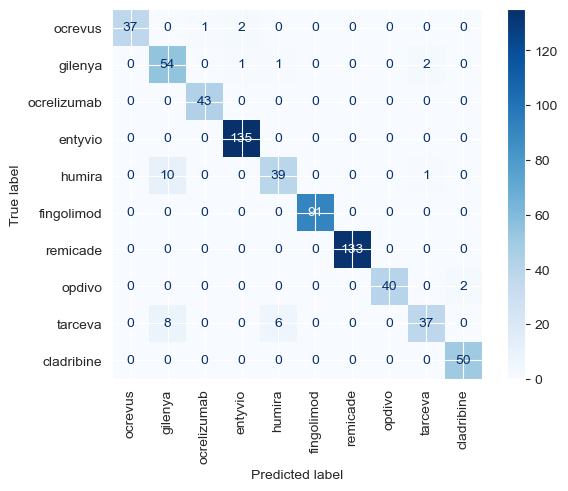

In [22]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=labels)
matrix.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.show()

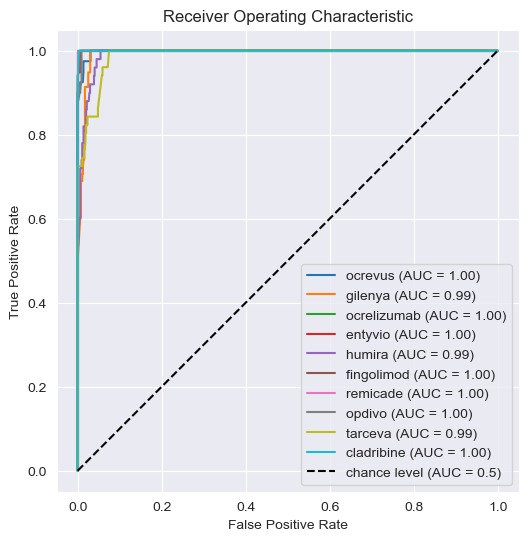

In [23]:
y_probs = clf.predict_proba(x_test)
fig, ax = plt.subplots(figsize=(6, 6))

for label in range(10):
    RocCurveDisplay.from_predictions(
        y_binarized[:, label],
        y_probs[:, label],
        name=f"{labels[label]}",
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

In [24]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier()
}

preds = {}
probs = {}
train_sizes = {}
train_scores = {}
test_scores = {}
fit_times = {}
score_times = {}

for model_name, model in models.items():
    clf = model
    clf.fit(x_train, y_train)
    preds[model_name] = clf.predict(x_test)
    probs[model_name] = clf.predict_proba(x_test)


In [25]:
for model_name in models.keys():
    print(model_name)
    print(classification_report(y_test, preds[model_name], target_names=labels))

    # cm = confusion_matrix(y_test, preds[model_name])
    # print(cm)

    acc_score = accuracy_score(preds[model_name], y_test)
    acc_score = acc_score * 100
    print('Accuracy of testing set {}%'.format(acc_score))

LogisticRegression
              precision    recall  f1-score   support

     ocrevus       0.84      0.95      0.89        40
     gilenya       0.76      0.81      0.78        58
 ocrelizumab       0.81      0.91      0.86        43
     entyvio       0.95      0.93      0.94       135
      humira       0.66      0.76      0.70        50
  fingolimod       0.90      0.98      0.94        91
    remicade       0.99      0.93      0.96       133
      opdivo       0.95      0.95      0.95        42
     tarceva       0.83      0.59      0.69        51
  cladribine       0.96      0.88      0.92        50

    accuracy                           0.89       693
   macro avg       0.87      0.87      0.86       693
weighted avg       0.89      0.89      0.89       693

Accuracy of testing set 88.74458874458875%
DecisionTree
              precision    recall  f1-score   support

     ocrevus       0.91      0.97      0.94        40
     gilenya       0.80      0.84      0.82        58
 oc

LogisticRegression


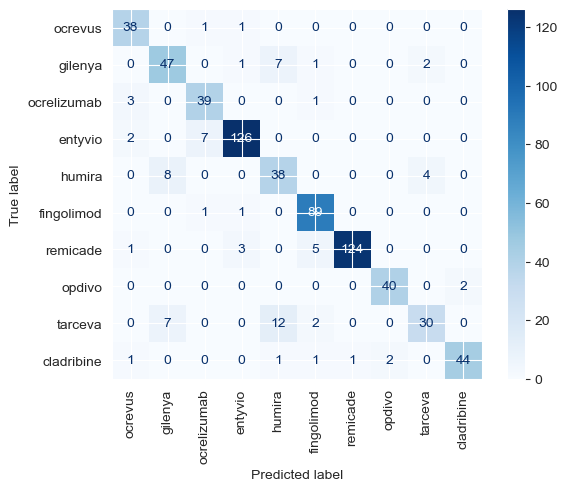

DecisionTree


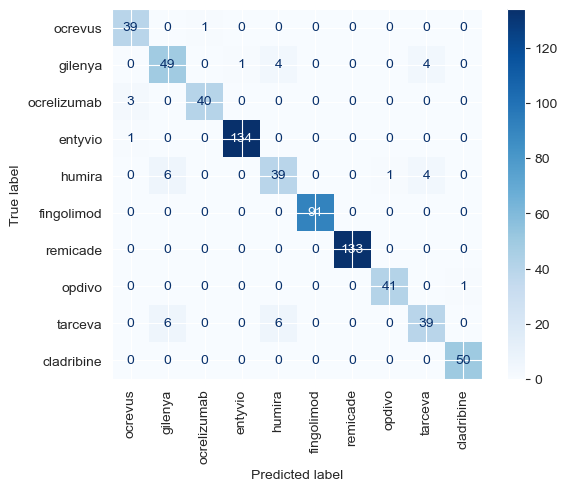

In [26]:
for model_name in models.keys():
    print(model_name)
    matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, preds[model_name]), display_labels=labels)
    matrix.plot(cmap="Blues")
    plt.xticks(rotation=90)
    plt.show()

LogisticRegression


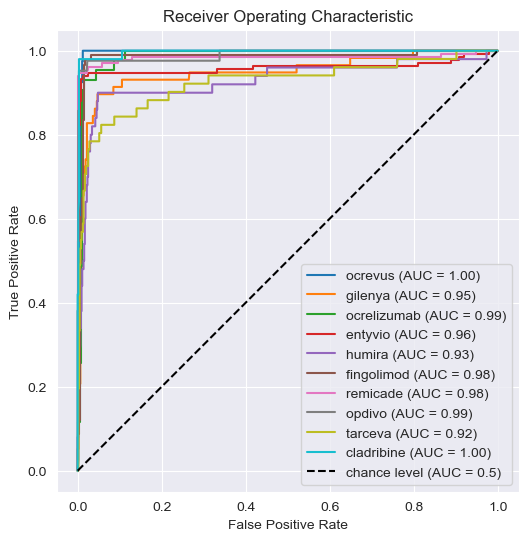

DecisionTree


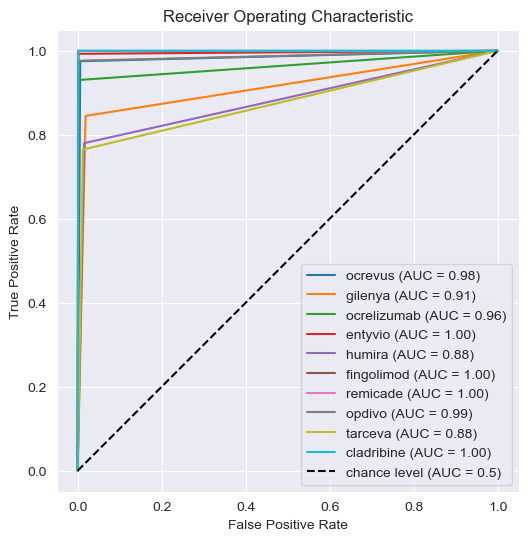

In [27]:
for model_name in models.keys():
    print(model_name)
    fig, ax = plt.subplots(figsize=(6, 6))
    for label in range(10):
        RocCurveDisplay.from_predictions(
            y_binarized[:, label],
            probs[model_name][:, label],
            name=f"{labels[label]}",
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend()
    plt.show()